# Garmin Year(s) in Review (2017 - 2020)
> Other services I used provided me a year in review. Have to make my own for Garmin.. and make it a little more interesting. 

- toc: true
- branch: master
- badges: false
- comments: false
- categories: [jupyter, fitness]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: false

Very simple exercise in looking at data from my runs that are stored in Garmin. Includes all of my runs up to the end of 2020.  

I’m collecting my data directly from Garmin’s website – https://connect.garmin.com/modern/activities, filtering specifically for my running activities. Garmin allows you to export the data directly to .csv.

My goal with looking at this data is to understand the following:

- How did I perform in 2020? 
- What should I aim to improve in 2021?

In [1]:
#hide

#main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time


#no idea what these are for
import seaborn as sns #importing seaborn module 
import warnings
warnings.filterwarnings('ignore')  #this will ignore the warnings.it wont display warnings in notebook
#plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
plt.rcParams['figure.figsize']=[6,3]
plt.rcParams['figure.dpi']=80

# The Data

In [2]:
#hide
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 15)
garmin_data = pd.read_csv("data/garmin-runs.csv")

## Understanding the Data

First things first, let's get an idea of what the data looks like. 

In [3]:
garmin_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Type             392 non-null    object 
 1   Date                      392 non-null    object 
 2   Favorite                  392 non-null    bool   
 3   Title                     392 non-null    object 
 4   Distance                  392 non-null    float64
 5   Calories                  392 non-null    object 
 6   Time                      392 non-null    object 
 7   Avg HR                    392 non-null    object 
 8   Max HR                    392 non-null    object 
 9   Aerobic TE                392 non-null    object 
 10  Avg Run Cadence           392 non-null    object 
 11  Max Run Cadence           392 non-null    object 
 12  Avg Pace                  392 non-null    object 
 13  Best Pace                 392 non-null    object 
 14  Elev Gain 

### Prep the Data

Looking at the initial review, a lot of these fields are objects when I really want to capture them as integers or floats. There are also some simplified fields I'll want to have in my analysis:
- Year
- Month
- Day of the Week
- Time of Day (Morning, Afternoon, Late Afternoon, Evening)

In addition, I'll want to standardize some elements so they are bit easier for me to manage and analyze.

- Pace is currently stored as minutes per mile. I will change to miles per hour.
- Time is currently stored as HH:MM. I will change this to total elapsed minutes. 

Finally, Garmin does not have null values. In areas where the value is null, Garmin captures it as "--". I will clean this up and make these null.

This results in the following: 

In [4]:
#function to remove "--"
def clean_na(val, pace=False):
    if pace == True:
        newval = val.replace("--", "99:99")
    else:
        newval = val.replace("--", '0').replace(',','')
    return str(newval)

#function to determine 
def time_of_day(date):
    morn_start = dt.time(6,00)
    afternoon_start = dt.time(12,00)
    late_afternoon_start = dt.time(15,00)
    evening_start = dt.time(18,00)
    
    time_of_run = dt.datetime.time(date)
    
    if evening_start <= time_of_run < morn_start:
        return "Evening"
    elif morn_start <= time_of_run < afternoon_start:
        return "Morning"
    elif afternoon_start <= time_of_run < late_afternoon_start:
        return "Afternoon"
    elif late_afternoon_start <= time_of_run < evening_start:
        return "Late Afternoon"




#fix data types
garmin_data['Date'] = garmin_data['Date'].astype('datetime64')
garmin_data['Day of Week'] = garmin_data['Date'].dt.day_name()
garmin_data['Favorite'] = garmin_data['Favorite'].astype('bool')
garmin_data['Calories'] = garmin_data['Calories'].str.replace(',','')
garmin_data['Calories'] = garmin_data['Calories'].apply(clean_na).astype(int)
garmin_data['Avg HR'] = garmin_data['Avg HR'].apply(clean_na).astype(int)
garmin_data['Max HR'] = garmin_data['Max HR'].apply(clean_na).astype(int)
garmin_data['Aerobic TE'] = garmin_data['Aerobic TE'].apply(clean_na).astype(float)
garmin_data['Avg Run Cadence'] = garmin_data['Avg Run Cadence'].apply(clean_na).astype(int)
garmin_data['Max Run Cadence'] = garmin_data['Max Run Cadence'].apply(clean_na).astype(int)
garmin_data['Elev Gain'] = garmin_data['Elev Gain'].apply(clean_na).astype(int)
garmin_data['Elev Loss'] = garmin_data['Elev Loss'].apply(clean_na).astype(int)

#converting my total elapsed time to minutes, rounding & adjust column name
garmin_data.rename(columns = {'Time' : 'Minutes Elapsed'}, inplace= True)
garmin_data['Minutes Elapsed'] = garmin_data['Minutes Elapsed'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]) + round(float(x[2])/60,1))
garmin_data['Climb Time'] = garmin_data['Climb Time'].str.split(':').apply(lambda x: int(x[0]) + float(x[1])/60)

#convert pace to mph
garmin_data['Avg Pace'] = garmin_data['Avg Pace'].apply(clean_na, pace=True).str.split(':').apply(lambda x: 60/(int(x[0]) +  int(x[1])/60))
garmin_data['Best Pace'] = garmin_data['Best Pace'].apply(clean_na, pace=True).str.split(':').apply(lambda x: 60/(int(x[0]) +  int(x[1])/60))

#get date attributes
garmin_data['Year'] = garmin_data['Date'].apply(lambda x: x.year)
garmin_data['Month'] = garmin_data['Date'].apply(lambda x: x.month)
garmin_data['Time of Day'] = garmin_data['Date'].apply(time_of_day)

# clean up unused date 
garmin_data = garmin_data.drop(columns=['Favorite', 'Avg Vertical Ratio', 'Avg Vertical Oscillation', 'Training Stress Score®', 'Grit', 'Flow','Bottom Time', 'Min Temp', 'Surface Interval', 'Decompression', 'Best Lap Time', 'Number of Laps', 'Max Temp'])


Let's take a look at the data again, now that we've set it up.

In [5]:
garmin_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Activity Type      392 non-null    object        
 1   Date               392 non-null    datetime64[ns]
 2   Title              392 non-null    object        
 3   Distance           392 non-null    float64       
 4   Calories           392 non-null    int64         
 5   Minutes Elapsed    392 non-null    float64       
 6   Avg HR             392 non-null    int64         
 7   Max HR             392 non-null    int64         
 8   Aerobic TE         392 non-null    float64       
 9   Avg Run Cadence    392 non-null    int64         
 10  Max Run Cadence    392 non-null    int64         
 11  Avg Pace           392 non-null    float64       
 12  Best Pace          392 non-null    float64       
 13  Elev Gain          392 non-null    int64         
 14  Elev Loss 

Looking much better. Now that we have our data set up, let's dive into some questions that I'm curious about. 

- What have my running habits looked like over the years?
- What has been my average overall pace?
- Which time / day / month do I run the most?
- Which time / day / month am I most effective?

Other questions I'm curious about...

- How many total calories have I burned? (in pounds)
- Has my average heart rate gotten "better" over time? (My hypothesis is that, as I get healthier, I can maintain a faster pace with a lower heart rate)

Have a lot of other questions.. especially related to "Best Pace" and how reliablem that data is. For example, can I predict which days I'll have my best pace?

## Number of Runs 

In [6]:
num_runs = garmin_data.pivot_table('Title', index="Year", columns = 'Month', aggfunc='count', fill_value=0)

num_runs.style.background_gradient(cmap='Blues')

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2017,0,0,0,0,0,0,10,10,11,12,5,7
2018,8,25,30,27,21,23,13,10,7,0,0,1
2019,0,0,2,0,0,0,13,10,15,25,13,2
2020,8,1,0,0,0,0,0,22,20,9,18,10
2021,4,0,0,0,0,0,0,0,0,0,0,0


Looking at this, it's clear where I ran the most. 2018 was a great year.. I do seem to have "periods" of running.

- Period 1: July 2017 - September 2018
- Period 2: July 2019 - January 2020
- Period 3: August 2020 - Today

Looking at this, I'd assume that I was the best runner in Period 1. But let's look at my data in a different way. Some other metrics that are important to understand: my average pace, my average distance and my monthly distance.

## Avg Pace (mph)

In [7]:
avg_pace = np.round(garmin_data.pivot_table('Avg Pace', index="Year", columns = 'Month', aggfunc='mean', fill_value=0, margins=False),2)

avg_pace

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2017,0.00,0.00,0.00,0.0,0.00,0.00,5.32,5.60,5.63,5.32,5.59,5.26
2018,5.58,5.82,5.60,6.0,5.79,5.63,5.68,5.53,5.89,0.00,0.00,4.46
2019,0.00,0.00,4.53,0.0,0.00,0.00,5.08,5.40,5.35,5.47,5.59,5.76
2020,5.06,5.48,0.00,0.0,0.00,0.00,0.00,5.06,5.36,5.64,5.69,5.49
2021,6.04,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Total Distance (miles)

In [8]:
total_distance = garmin_data.pivot_table('Distance', index="Year", columns = 'Month', aggfunc='sum', fill_value=0, margins=False)
total_distance

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2017,0.00,0.00,0.00,0.00,0.00,0.00,37.42,24.54,36.78,35.27,12.68,15.29
2018,17.18,56.84,55.44,55.48,42.02,50.95,33.57,20.36,8.97,0.00,0.00,3.20
2019,0.00,0.00,4.17,0.00,0.00,0.00,24.93,22.86,33.06,44.25,19.47,3.12
2020,25.14,2.00,0.00,0.00,0.00,0.00,0.00,76.43,80.49,41.23,56.40,30.43
2021,11.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Average Distance (miles)

In [9]:
avg_distance = np.round(garmin_data.pivot_table('Distance', index="Year", columns = 'Month', aggfunc='mean', fill_value=0, margins=False), 2)

(0.0, 82.0)

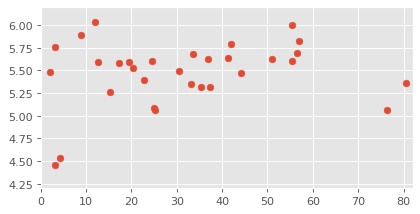

In [10]:
month = 10
year = 2020

num_runs.loc[year][month]
avg_pace.loc[year][month]
total_distance.loc[year][month]
avg_distance.loc[year][month]

fig, ax = plt.subplots()
ax.scatter(total_distance, avg_pace)
ax.set_ylim([4.2,6.2])
ax.set_xlim([0,82])
#avg_pace.loc[year]

In [11]:
np.round(garmin_data.pivot_table('Distance', index="Day of Week", columns = 'Time of Day', aggfunc='mean', fill_value=0, margins=False), 2)



Time of Day,Afternoon,Late Afternoon,Morning
Day of Week,,,
Friday,2.83,1.58,2.13
Monday,2.12,2.72,2.06
Saturday,3.40,4.46,2.93
Sunday,3.31,2.13,4.03
Thursday,1.48,2.85,2.23
Tuesday,0.00,2.45,2.49
Wednesday,0.00,2.47,1.78


# Potential Questions to Ask

## Which day & time am I the fastest?

## Am I most effective in the morning or afternoon?

## How many calories to I burn per minute, while running?

## If I were to continue my trend of faster pace, when could I run a 7 minute mile?

## What is the relationship between weekly mileage and weekly pace change?



In [12]:

sns.set()
data.pivot_table('Title', index="Day of Week", columns="Time of Day", aggfunc='count').plot.bar()
data.pivot_table('Title', index="Year", columns="Day of Week", aggfunc='count')
plot.sc
### Which day do I run the most?

#data.pivot_table('Avg Pace', index=data['Year'], columns="Time of Day", aggfunc='mean')

NameError: name 'data' is not defined

In [ ]:
garmin_data.pivot_table('Title', index="Year", columns = 'Month', aggfunc='count', fill_value=0)

In [ ]:
#3 main periods of running recorded in Garmin. 
# 7/2017 - 11/2018
period_1 = [datetime.date(2017, 7,1), datetime.date(2018,10,13)]
# ax.set_xlim([datetime.date(2017, 7,1), datetime.date(2018,11,1)])
# 7/2019 - 12/2019
period_2 = [datetime.date(2019, 7,1), datetime.date(2019,12,1)]
# ax.set_xlim([datetime.date(2019, 7,1), datetime.date(2019,12,1)])
# 1/2020 - 12/2020
period_3 = [datetime.date(2020, 8,1), dt.datetime.now()]
#ax.set_xlim([datetime.date(2020, 8,1), datetime.date(2020,11,1)])


In [ ]:
data.pivot_table('Distance', index="Year", columns = 'Month', aggfunc='sum', fill_value=0)

In [ ]:
data.pivot_table('Avg Pace', index="Year", columns = 'Month', aggfunc='mean', fill_value=0)